# Lorenz System - PySINDy Application & Neural Network Prediction

## COLSA Corporation 

### Raj Garkhedkar, DACS Lab Summer 2021 Intern

## Table Of Contents
#### Lorenz System Explained, Visualized, & Animated
#### Attractor w/ PySINDy Implementation - DDSE Book
#### My Implementation Using PySINDy & Analysis
#### Neural Network For System Evolution Prediction

In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import IPython.display as IPdisplay
import scipy.sparse as sparse
import os
import glob
import time
import warnings
import pandas as pd
import pylab as pl
import math
import itertools
import operator
import scipy.misc
import IPython.display as ipdisplay
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from numpy.fft import rfft,irfft,rfftfreq
from time import process_time
from scipy.integrate import odeint, solve_ivp
from scipy.fftpack import diff as diffy
from scipy.sparse import dia_matrix, csc_matrix
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import rcParams
from PIL import Image as pil
from PIL import ImageDraw as draw
from subprocess import check_output
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from IPython.core.display import Image

%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 2000
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)
family = 'Times New Roman'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')

###### Links

[UCSB MATLAB Paper](https://web.math.ucsb.edu/~jhateley/paper/lorenz.pdf)

[NASA Paper on SINDy & ML](https://ntrs.nasa.gov/api/citations/20200001544/downloads/20200001544.pdf) *big file, long loading time

[PySINDy Docs](https://pysindy.readthedocs.io/en/latest/index.html)

[PySINDy Examples (from docs)](https://pysindy.readthedocs.io/en/latest/examples/3_original_paper.html)

[PySINDy Publication - Official Paper](https://www.researchgate.net/publication/340806743_PySINDy_A_Python_package_for_the_Sparse_Identification_of_Nonlinear_Dynamics_from_Data)

[PySINDy GitHub Page](https://github.com/dynamicslab/pysindy)

[Lorenz NN](https://gist.github.com/raspstephan/8e9ecc9f2b74e528dff8056a0e76846c?short_path=e703112#file-lorenztorch-ipynb)

[PySINDy Syntax & API Docs](https://pysindy.readthedocs.io/en/latest/api/pysindy.html)

[Lorenz FNN GitHub](https://github.com/williamgilpin/fnn)

[Chaos & Attractors](https://blogs.rstudio.com/ai/posts/2020-06-24-deep-attractors/)

[Arxiv of Time Series Reconstruction of Attractors](https://arxiv.org/abs/2002.05909)

[Learning Chaotic Dynamics Arxiv](https://arxiv.org/pdf/1903.10335.pdf)

[Deep Representation Learning for Dynamical Systems Arxiv](https://arxiv.org/pdf/2002.05111.pdf)

[Nonlinear LSTM repo](https://github.com/srpraveen97/LSTM_nonlinear)

[Neural ODE Repo](https://github.com/msurtsukov/neural-ode)

[Properly Seeding](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752)

[Seeding Jupyter Article](https://notebook.community/ageron/ml-notebooks/extra_tensorflow_reproducibility)

-- -- -- -- -- --

###### Foreword On Reproducibility:
So an issue I was occassionally running into was seeding for reproducibility. In the DDSE book and Brunton's work online, they've used `np.random.seed()` for seeding. It turns out that if not seeded, `RandomState` will read data from /dev/urandom or seed from the clock. They use 100 for their purposes to generate the same 100 but they use the command in that specific cell. My research on this topic led me to information that says Jupyter can't recognize the seed in the cells where it's not explicitly declared, so using numpy to set the seed once won't do. As mentioned in the [Seeding Jupyter Article](https://notebook.community/ageron/ml-notebooks/extra_tensorflow_reproducibility) article, it seems that the Python kernel must be started up with `PYTHONHASHSEED=0` declared explicitly. However, for multithreading and efficiency reasons, since I'm dealing with modeling dynamical systems with large matrix transformations, speed is paramount & a careful cooperation between global reproducibility & efficiency must be formed... therefore I can't guarantee the results will be fully reproducible on any system, but, I will seed everytime in order to ensure either same or extremely similar results. I've tried to control & tame the 'randomness' as much as possible, in short. 

## Lorenz System

The Lorenz system is a system of ordinary differential equations (ODE's) which has very chaotic solutions based on initial conditions. The Lorenz Attractor is a set of specific chaotic solutions for the Lorenz system which, when plotted, resembles a butterfly. 

Mathematically, the system of equations are: 

$$\frac{dx}{dt} = \sigma(y-x)$$
<br>
$$\frac{dy}{dt} = x(\rho - z) - y$$
<br>
$$\frac{dz}{dt} = xy + \beta z$$

Below code is a regular NumPy implementation to demonstrate how it's supposed to look. 

In [2]:
# Seeding cell



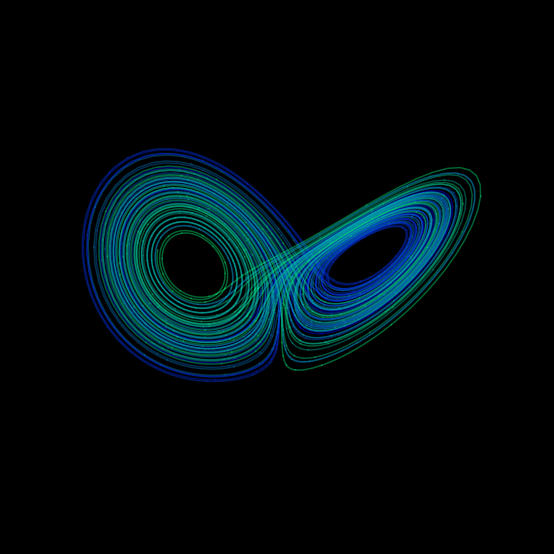

If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above


In [3]:
WIDTH, HEIGHT, DPI = 1000, 750, 100

# Unhash below to play around with different values

# sigma = float(input("Enter A Number: "))
# beta = float(input("Enter A Number: "))
# rho = float(input("Enter A Number: "))

# u0 = float(input("Enter An Initial Condition Number: "))
# v0 = float(input("Enter An Initial Condition Number: "))
# w0 = float(input("Enter An Initial Condition Number: "))


# Lorenz paramters and initial conditions.
sigma = 10
beta = 2.66667
rho = 28
u0 = -8
v0 = 8
w0 = 27

# Maximum time point and total number of time points.
tmax, n = 100, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X
    dx = - sigma * (x - y)
    dy = rho * x - y - x * z
    dz = - beta * z + x * y
    return dx, dy, dz

# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.gca(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in color across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)
ax.set_axis_off()
plt.show()

print('If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above')

So that's what it looks like with what the conditions/parameters I input... looks cool (or bad, yikes)

Hint (enter the following, in order, for a cool attractor):
`10`
`2.66667`
`28`
`-8`
`8`
`27`
OR
`20`
`6.7435`
`80`
`2`
`2`
`2`

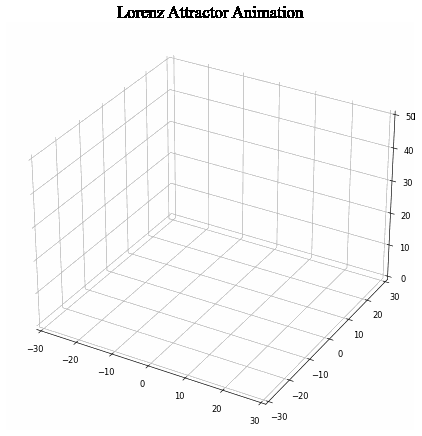

In [4]:
# Burner folder to temporary store images
folder = '/Users/rajgark/Desktop/PySINDy/AttractorImages' 

# Function for lorenz system
def lorenz_animated(current_state, t):
    x, y, z = current_state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

def plot_lorenz(xyz, n):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1,1,1,1))
    ax.yaxis.set_pane_color((1,1,1,1))
    ax.zaxis.set_pane_color((1,1,1,1))
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.7)
    ax.set_xlim((-30,30))
    ax.set_ylim((-30,30))
    ax.set_zlim((0,50))
    ax.set_title('Lorenz Attractor Animation', fontproperties=title_font)
    
    plt.savefig('{}/{:03d}.png'.format(folder, n), dpi=60, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    
def chunky(full_list, size):
    size = max(1,size)
    chunks = [full_list[0:i] for i in range(1,len(full_list) + 1, size)]
    return chunks

start = 0
end = 60
interval = 100
initial_state = [0.1,0,0]
timepoints = np.linspace(start, end, end*interval)
chunks = chunky(timepoints, size = 20)
points = [odeint(lorenz_animated, initial_state, chunk) for chunk in chunks ]
for n, point in enumerate(points):
    plot_lorenz(point, n)
    

fp_in = '/Users/rajgark/Desktop/PySINDy/AttractorImages/*.png'
fp_out = '/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif'

img, *imgs = [pil.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp = fp_out, format = 'gif', append_images = imgs, save_all = True, duration = 200, loop = 0)
IPdisplay.Image('/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif')

In [5]:
# Deletes all images captured to make gif
files = glob.glob('/Users/rajgark/Desktop/PySINDy/AttractorImages/*')
for f in files:
    os.remove(f)

## Lorenz  Attractor w/ PySINDy Implementation

This PySINDy implementation is guided by the original docs.

In [6]:
def sindylorenz(x, t):
    return [
        10 * (x[1] - x[0]),
        x[0] * (28 - x[2]) - x[1],
        x[0] * x[1] - 8 / 3 * x[2],
    ]
dt = 0.001
t_train = np.arange(0,100,dt)
print('t_train size: ',t_train.size)
x0_train = [-8, 8, 27] 
x_train = odeint(sindylorenz, x0_train, t_train)
x_dot_train_measured = np.array([sindylorenz(x_train[i], 0) for i in range(t_train.size)])

t_train size:  100000


In [7]:
x_train

array([[-8.        ,  8.        , 27.        ],
       [-7.84087856,  7.98355342, 26.86488252],
       [-7.68350838,  7.96625052, 26.73151873],
       ...,
       [-5.31069055, -8.18331516, 16.83582711],
       [-5.33952879, -8.23455986, 16.83464659],
       [-5.36859135, -8.28608134, 16.83398129]])

In [8]:
t_train

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 9.9997e+01, 9.9998e+01,
       9.9999e+01])

In [9]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

optimize = ps.STLSQ(threshold = threshold)
featurelib = ps.PolynomialLibrary(degree = polynomial_order)

model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(size = x_train.shape), quiet = True)
#models = []
#tsim = np.arange(0,20,dt)
#xsim = []
#noises = [1e-3, 1e-3, 1e-2, 1e-1, 1.0]

# for eps in noises:
#     model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
#     model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(scale = eps, size = x_train.shape), quiet = True)
#     models.append(model)
#     xsim.append(model.simulate(x_train[0], tsim))

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=5),
      feature_names=['x0', 'x1', 'x2'], optimizer=STLSQ(threshold=0.05))

The hashed out code is from the docs, I had it to debug. The optimizer actually can choose random values so it's important to make sure the notebook is seeded for reproducibility.

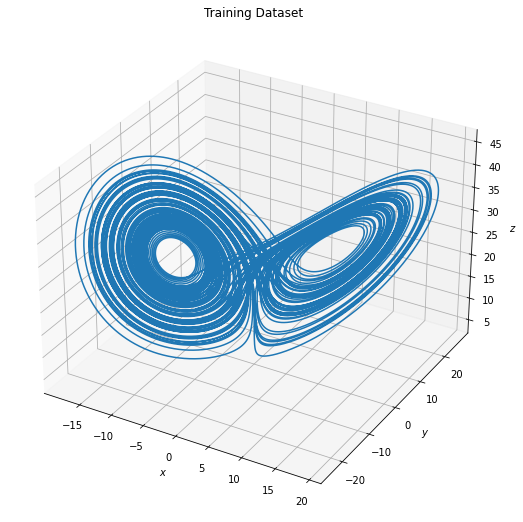

In [10]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_train.size, 0],
    x_train[: t_train.size, 1],
    x_train[: t_train.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

To preface the above plot, I should say that I'm not sure what it will look like everytime the notebook is run. All of yesterday, 10 June, I went over my code ~ 35 times to ensure everything is working as it should, and the output of PySINDy attractor above was just one line and one swirl. Then in the morning on 11 June I ran the notebook and it actually looks like how the system should. It doesn't quite look exactly like Prof. Brunton's on the PySINDy docs, but it does look like a Lorenz attractor. 

In [11]:
model.print()

x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


`x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1`

Those should be the outputs of the above cell, this is with an optimizer and feature library

In [12]:
t_test = np.arange(0, 15, dt)
x0_test = np.array([-8,7,15])
x_test = odeint(sindylorenz, x0_test, t_test)

Above I've done a test set on a trajectory guided through the discovery made in the train set. The initial conditions are different here, so an approximation made here, if accurate, means the model is behaving like a good guy

In [13]:
t_test.size

15000

In [14]:
x_test.size

45000

Ignore above output, done for my testing.

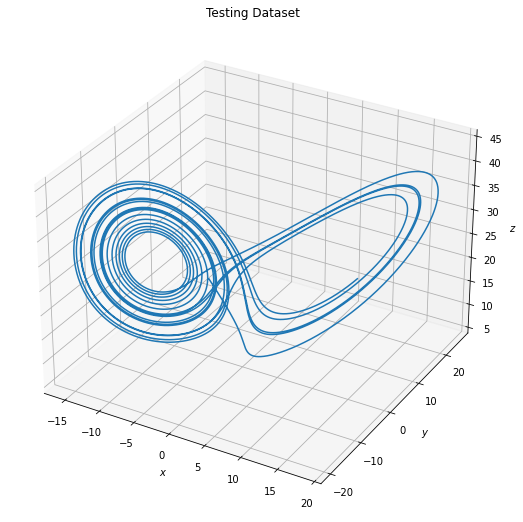

In [15]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_test[: t_test.size, 0],
    x_test[: t_test.size, 1],
    x_test[: t_test.size, 2],
)
plt.title("Testing Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

The goal now will be to leverage the training dataset and testing dataset to make a simulation which goes forward in time accurately projecting the trajectory of the chaotic particles.
<br> 
After doing so, a neural network can be implemented (as done in DDSE pg. 216 by Brunton & Kutz) to create a robust system for modeling the lorenz system of equations.

### My Implementation

In [16]:
newdt = 0.002

t_trainset = np.arange(0, 100, newdt)
x0_trainset = [-8, 8, 27]
x_trainset = odeint(sindylorenz, x0_trainset, t_trainset)

newmodel = ps.SINDy()
newmodel.fit(x_trainset, t = newdt)
newmodel.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


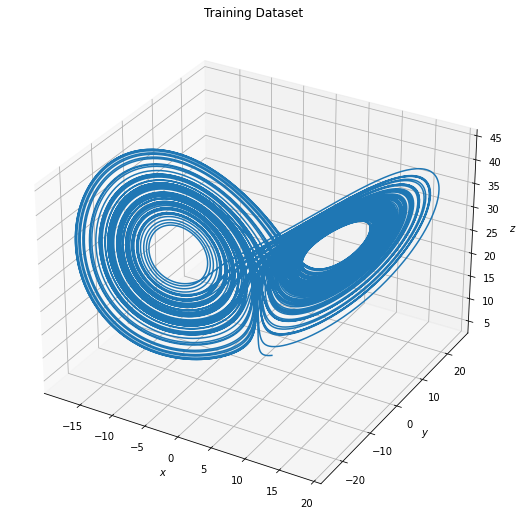

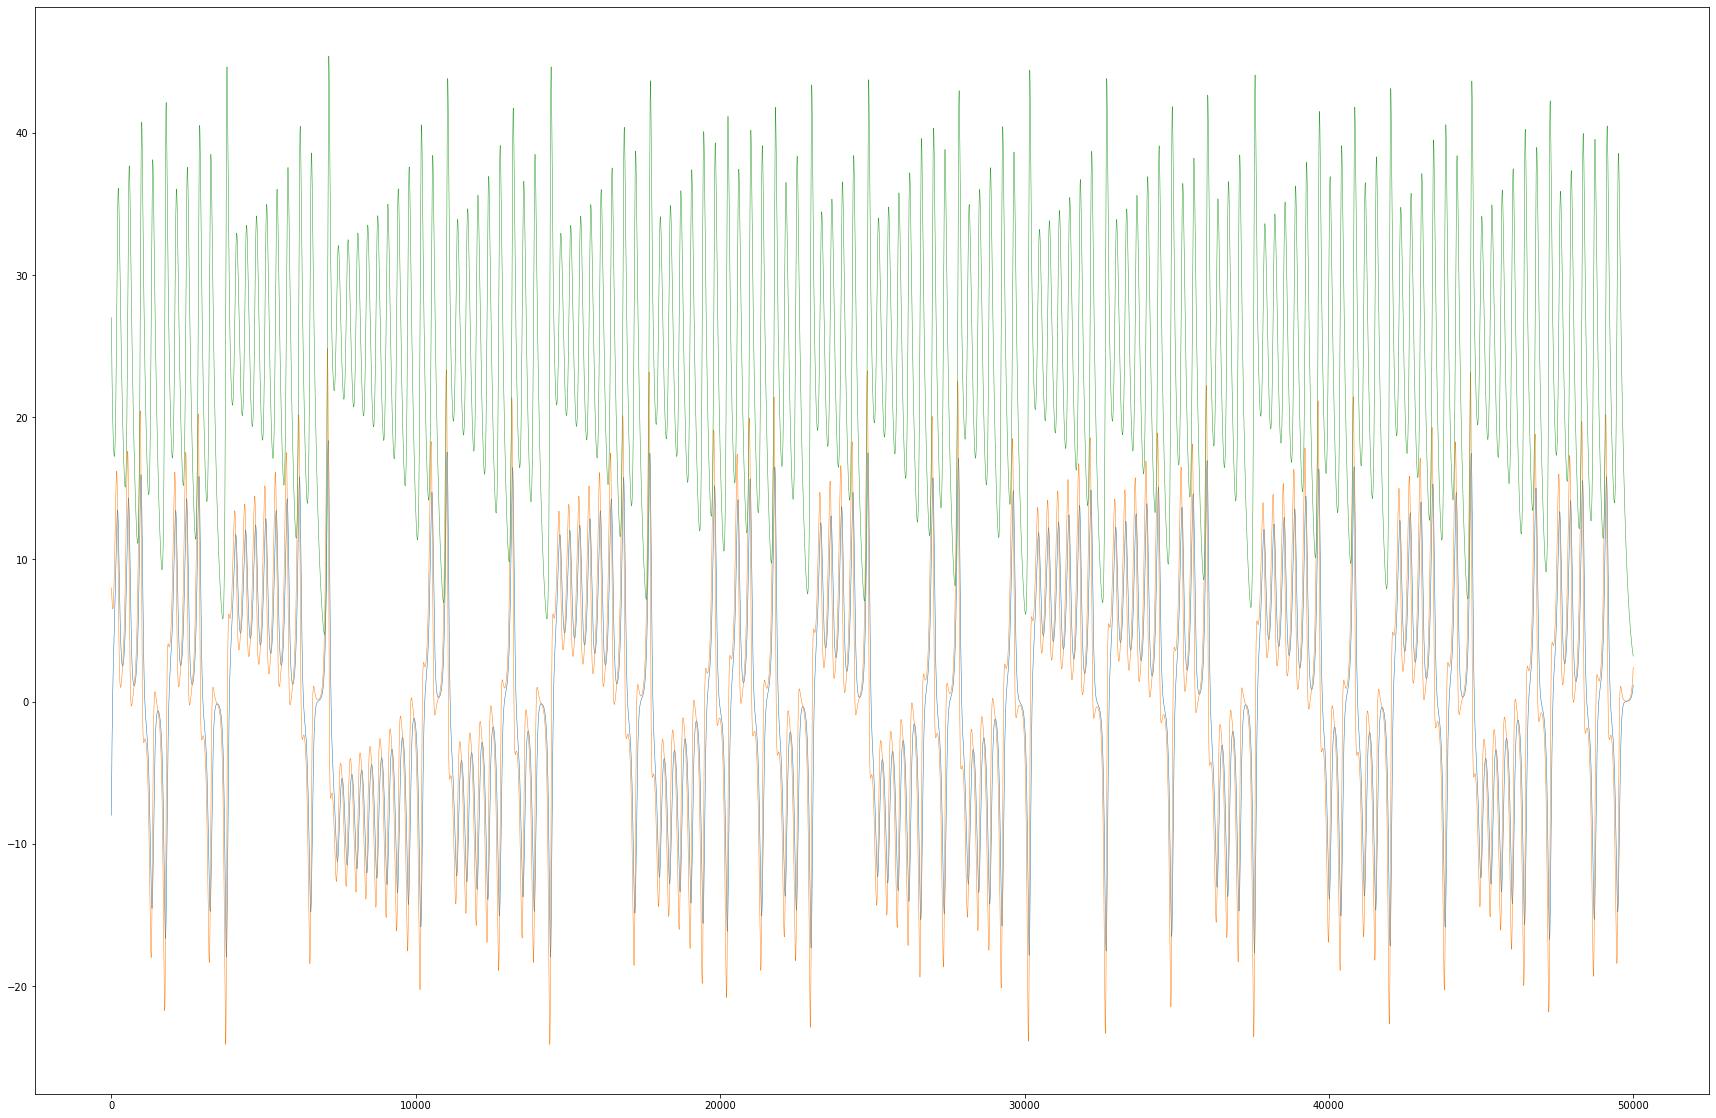

In [17]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_trainset[:t_trainset.size], linewidth = 0.5)
plt.show()

In [18]:
t_testset = np.arange(0, 15, newdt)
x0_testset = np.array([8, 7, 15])
x_testset = odeint(sindylorenz, x0_testset, t_testset)

print('Model score: %f' % model.score(x_testset, t = newdt))

Model score: 1.000000


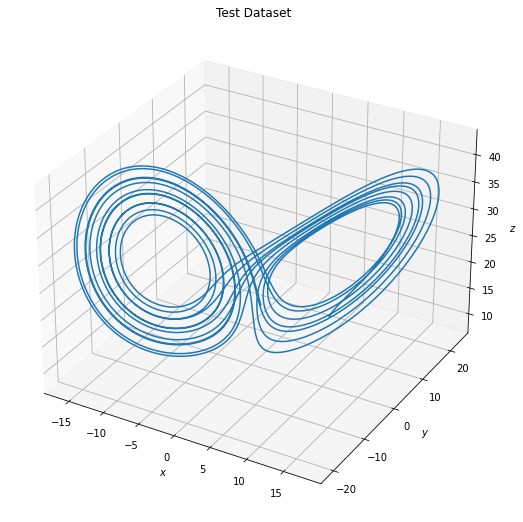

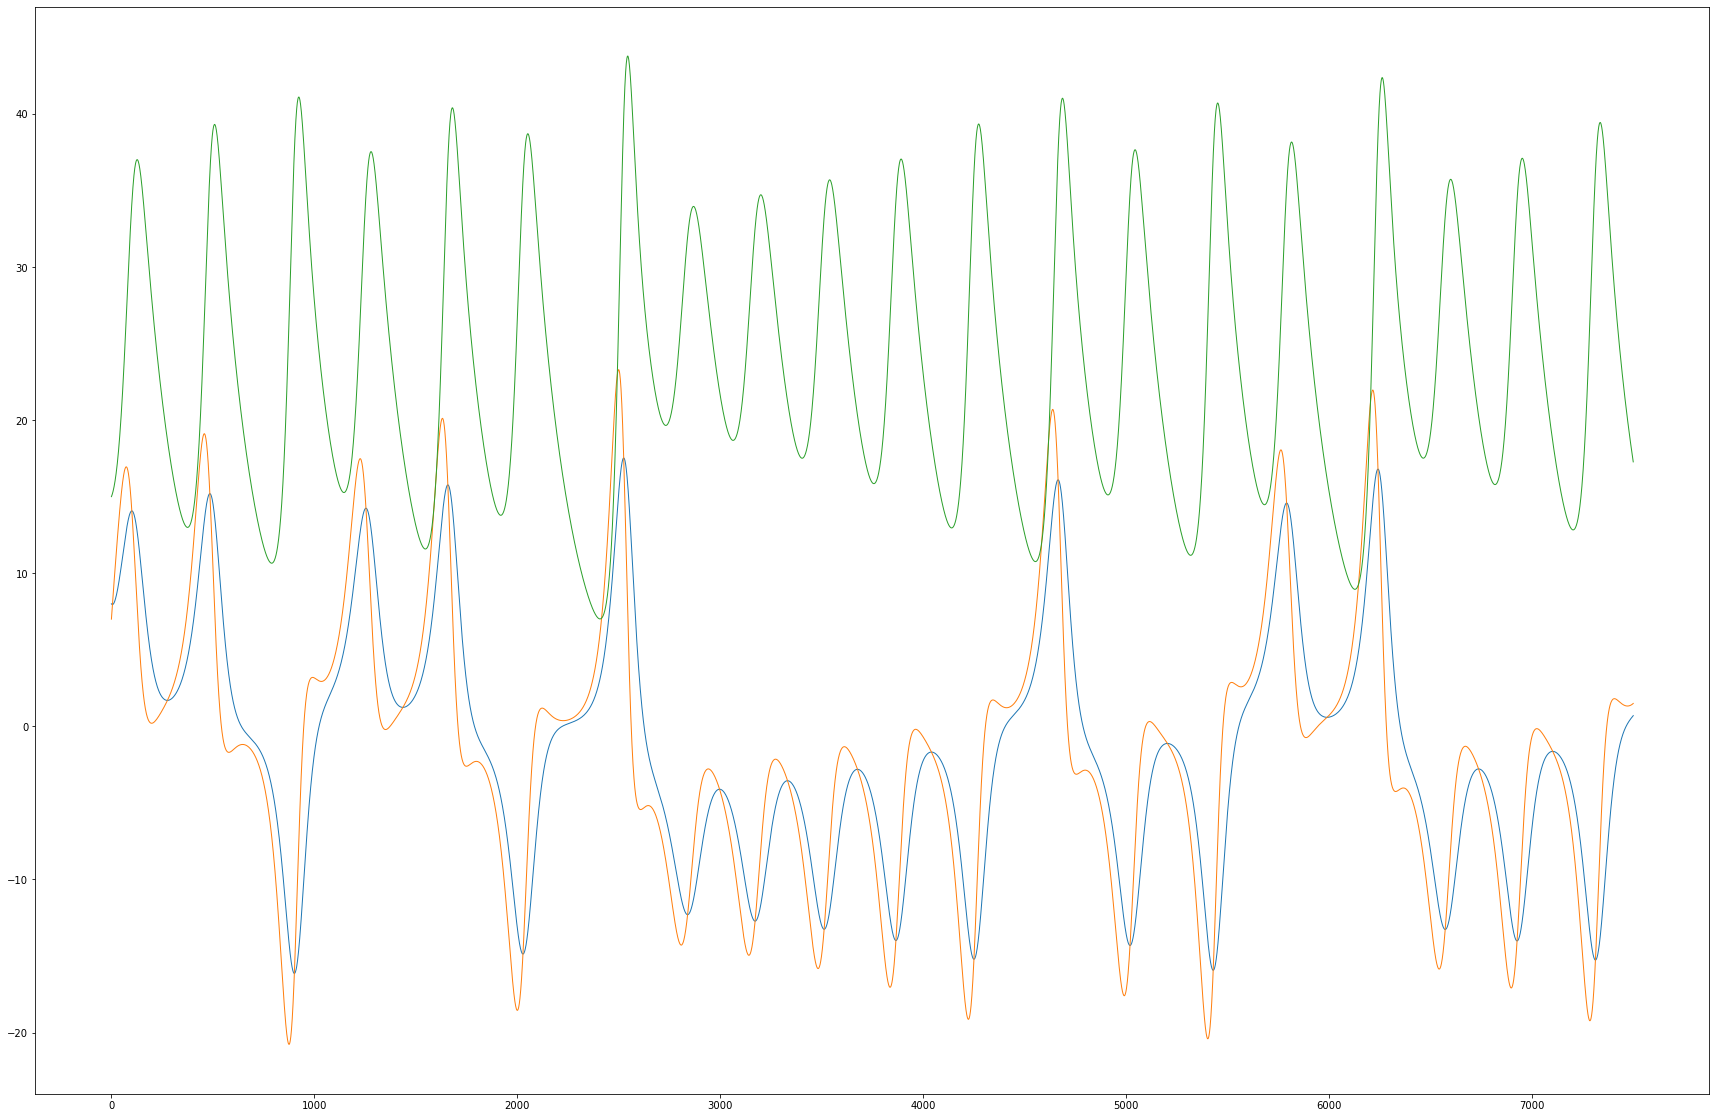

In [19]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
)
plt.title("Test Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_testset[:t_testset.size], linewidth = 1)
plt.show()

The test system above is with a smaller dataset and different initial conditions

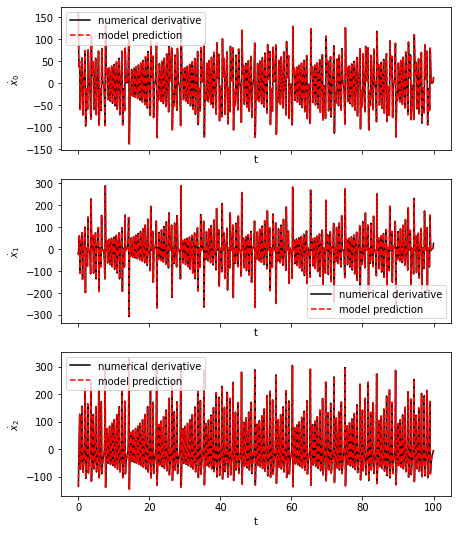

In [20]:
x_dot_train_pred = newmodel.predict(x_trainset)

x_dot_train_comp = newmodel.differentiate(x_trainset, t = newdt)

fig, axs = plt.subplots(x_trainset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_trainset.shape[1]):
    axs[i].plot(t_trainset, x_dot_train_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_trainset, x_dot_train_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

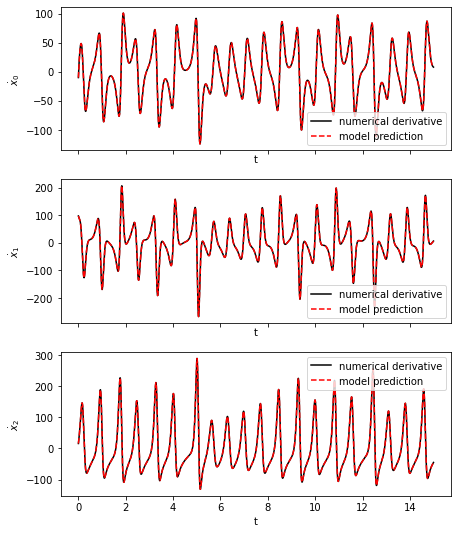

In [21]:
x_dot_test_pred = newmodel.predict(x_testset)

x_dot_test_comp = newmodel.differentiate(x_testset, t = newdt)

fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_dot_test_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_testset, x_dot_test_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

In [22]:
x_test_sim = newmodel.simulate(x0_testset, t_testset)
x_test_sim.shape

(7500, 3)

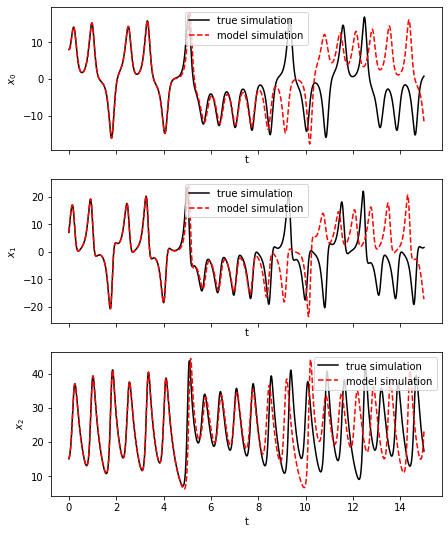

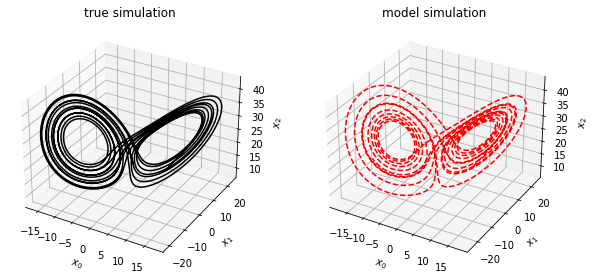

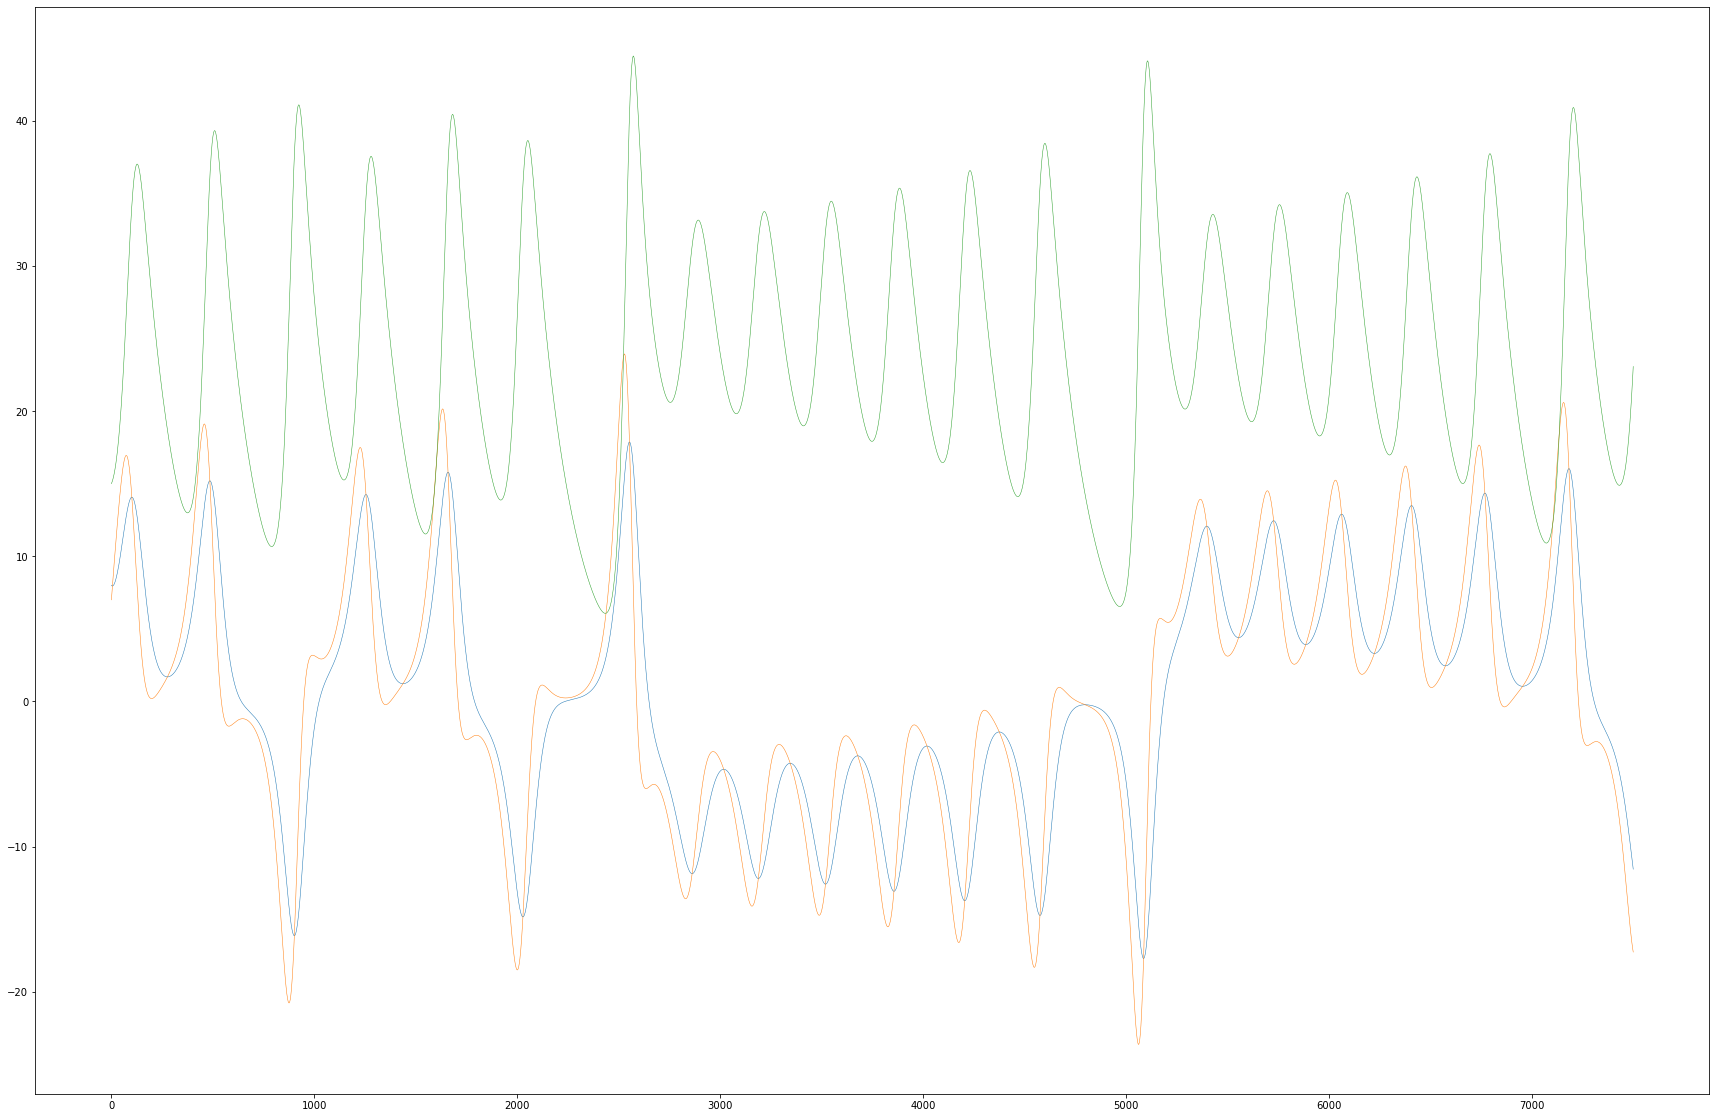

In [26]:
fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_testset[:, i], 'k', label='true simulation')
    axs[i].plot(t_testset, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_testset[:, 0], x_testset[:, 1], x_testset[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_test_sim[:t_testset.size], linewidth = 0.5)
plt.show()

### Measure only $x$ states & compute derivatives

In [27]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

t_sim = np.arange(0, 20, newdt)
garbmodel = ps.SINDy(optimizer = optimize, feature_library = featurelib)
garbmodel.fit(x_trainset + np.random.normal(size = x_trainset.shape), t = newdt, quiet = True)
x_sim_nod = garbmodel.simulate(x_trainset[0], t_sim)

x_dot_train_measured_new = np.array([sindylorenz(x_trainset[i], 0) for i in range(t_trainset.size)])

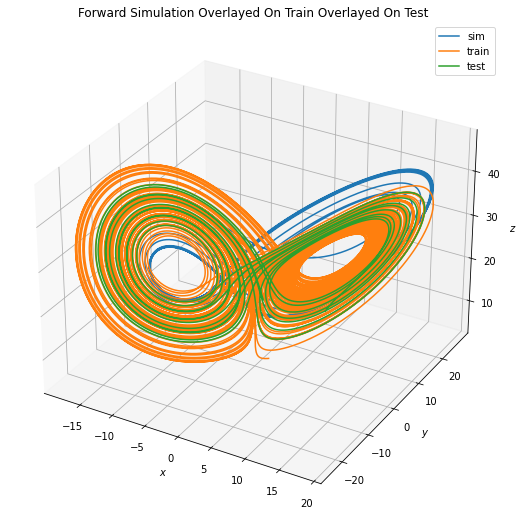

In [28]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
# Blue
pl1 = ax.plot(
    x_sim_nod[: t_sim.size, 0],
    x_sim_nod[: t_sim.size, 1],
    x_sim_nod[: t_sim.size, 2],
    label='sim'
)
# Orange
pl2 = ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
    label='train'
)
# Green
pl3 = ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
    label='test'
)
plt.title("Forward Simulation Overlayed On Train Overlayed On Test")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
#ax.legend([pl1, pl2, pl3], ['Sim','Train','Test'])
ax.legend()
fig.show()

The training and simulation show a semblance of similarity, meaning the algorithm is needs a bit of tuning. If you notice the forward simulation (blue), it can be noticed that the blue appearing on the top right area is what the training matrix will look like if the algorithm continues differentiating forward, thus 'completing' it. Essentially showing how the system will evolve. 

In [29]:
seed = 100
np.random.seed(seed)
noisedt = 0.001
noise_t_train = np.arange(0, 20, noisedt)
noise_x0_train = [-8,8,27]
noise_x_train = odeint(sindylorenz, noise_x0_train, noise_t_train)
noise_xdot_train_measured = np.array([sindylorenz(noise_x_train[i], 0) for i in range(noise_t_train.size)])

poly = 5
threshold = 0.5

optimize = ps.STLSQ(threshold = threshold)
flib = ps.PolynomialLibrary(degree = poly)

noises = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

noisemodels = []
noise_t_sim = np.arange(0, 20, noisedt)
noise_x_sim = []

for levels in noises:
    noisemodel = ps.SINDy(optimizer = optimize, feature_library = flib,)
    noisemodel.fit(noise_x_train, t = noisedt, x_dot = noise_xdot_train_measured + np.random.normal(scale = levels, size = noise_x_train.shape), quiet = True)
    noisemodels.append(noisemodel)
    noise_x_sim.append(noisemodel.simulate(noise_x_train[0], noise_t_sim))

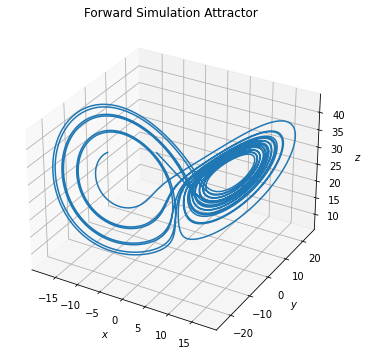

In [30]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131, projection="3d")
model_idx = 2
ax.plot(
    noise_x_sim[model_idx][:, 0],
    noise_x_sim[model_idx][:, 1],
    noise_x_sim[model_idx][:, 2],
)
plt.title("Forward Simulation Attractor")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.show()

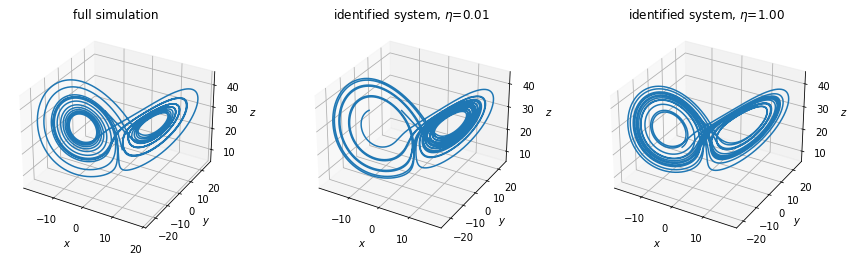

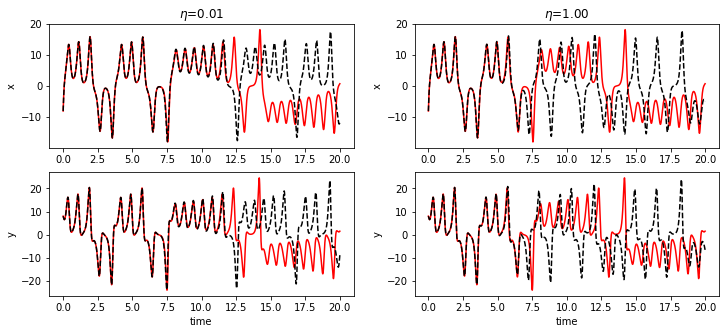

In [31]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    noise_x_train[: noise_t_sim.size, 0],
    noise_x_train[: noise_t_sim.size, 1],
    noise_x_train[: noise_t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(noise_x_sim[model_idx][:, 0], noise_x_sim[model_idx][:, 1], noise_x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noises[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(noise_x_sim[model_idx][:, 0], noise_x_sim[model_idx][:, 1], noise_x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noises[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 0], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noises[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 1], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 0], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noises[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 1], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

### Multiple Trajectories w/ Different Time Measurements

In [32]:
n_trajectories = 50

x0s = np.array([36, 48, 41]) * (np.random.rand(n_trajectories, 3) -0.5) + np.array([0,0,25])
x_train_multi = []
t_train_multi = []

for i in range(n_trajectories):
    n_samples = np.random.randint(250,3000)
    t = np.arange(0, n_samples * newdt, newdt)
    x_train_multi.append(odeint(sindylorenz, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t = newdt, multiple_trajectories = True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


In [33]:
print('Multi-trajectory array shape: ',np.shape(x_train_multi))
#t_train_multi

Multi-trajectory array shape:  (50,)


In [34]:
def multi_traj_plot(particle_ID):
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(131, projection="3d")
    multi_idx = particle_ID
    ax.plot(
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 0],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 1],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 2],
    )
    plt.title("Training Dataset")
    ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
    fig.show()

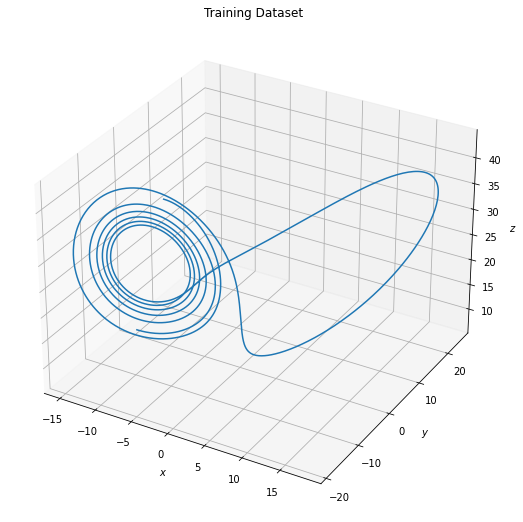

In [35]:
multi_traj_plot(2)

There are 50 (0-49) particles with random trajectories in the variable `x_train_multi` and to show the particle trajectory for any one of your choice, simply enter a number, 0-19, into the argument for the function `multi_traj_plot(enter#here)` 
<br>
The array consists of 20 particles with unique trajectories and times, so there is a very high likelihood of the selected pattern being obscure rather than a good looking attractor. This is due to the sampling rate being multiplied by `newdt` so regardless of the number, the infinitesimal increase dictates the shape of the array. Leaving it to the value it's set at is the best for reproducing valid data throughout the notebook, but newdt can be reassigned on the top of the cell right under the new multi-trajectory section if desired, being sure to hash it out while executing the notebook again.

### Lorenz System Neural Network

Since PySINDy has been implemented for model prediction & simulation, the next step is to create a neural network to predict the dynamical system's evolution spatially & temporally. The variable at hand is $x(t)$ where $x$ is the state of the system at time $t$, and the prediction (output) is $y(t+dt)$, or the state of the system after some infinitesimal time $dt$.

In DDSE pg. 216, Brunton & Kutz mention that the state of the system is given by the matrix $\textbf{x} = [x\ y\ z]^T$ and it'll require a nonlinear transfer function since the system itself is nonlinear.
<br>
<br>
The goal of the system is to produce an output matrix of the system at some arbitrary time after the measured state. 

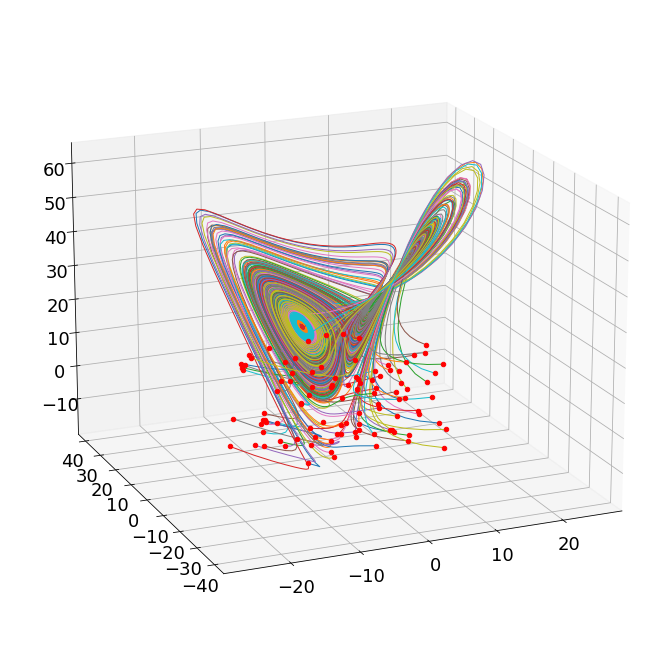

In [36]:
dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

In [37]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [38]:
class BobTheLorenzBuilder():
    def __init__(self, sigma, rho, beta, initparam1, initparam2, initparam3, dt):
#         self.beta = float(sigma)
#         self.rho = float(rho)
#         self.sigma = float(beta)
#         self.initparam1 = float(initparam1)
#         self.initparam2 = float(initparam2)
#         self.initparam3 = float(initparam3)
#         self.dt = float(dt)
        self.beta = beta
        self.rho = rho
        self.sigma = sigma
        self.initparam1 = initparam1
        self.initparam2 = initparam2
        self.initparam3 = initparam3
        self.dt = dt
        print('sigma: ', self.sigma, 'rho: ', self.rho, 'beta: ', self.beta, 'init params: ', [self.initparam1, self.initparam2, self.initparam3], 'dt: ', self.dt)
        print('Chosen dt: ', self.dt)
  
    def InitializeAttractor(self, x, t):
        return [
            self.sigma * (x[1] - x[0]),
            x[0] * (self.rho - x[2]) - x[1],
            x[0] * x[1] - self.beta * x[2],
        ]

    def MakeAttractor(self):
        t_range = np.arange(0, 100, self.dt)
        x0_params = [self.initparam1, self.initparam2, self.initparam3]
        print("x0 initialization parameters: ", x0_params)
        print("t_range: ", t_range)
        odesol = odeint(self.InitializeAttractor, x0_params, t_range)
        xdot_measured = np.array([self.InitializeAttractor(odesol[i], 0) for i in range(t_range.size)])
        self.odesol = odesol
        print('odesol matrix shape: ', odesol.shape)
        print('odesol matrix type: ', type(odesol))
        self.xdot_measured = xdot_measured
        self.t_range = t_range
        return odesol
    
    def MakeTensor(self):
        tens = self.odesol
        torchtensor = torch.tensor(tens)
        return torchtensor
    
    def VisualizeIt(self):
        fig = plt.figure(figsize=(30, 15))
        ax = fig.add_subplot(131, projection="3d")
        ax.plot(
            self.odesol[: self.t_range.size, 0],
            self.odesol[: self.t_range.size, 1],
            self.odesol[: self.t_range.size, 2],
        )
        plt.title("Attractor Visualized")
        ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
        fig.show()
        plt.figure(figsize = (30,20))
        plt.plot(self.odesol[:self.t_range.size], linewidth = 1)
        plt.show()


sigma:  10 rho:  28 beta:  2.66667 init params:  [-8, 8, 27] dt:  0.002
Chosen dt:  0.002
x0 initialization parameters:  [-8, 8, 27]
t_range:  [0.0000e+00 2.0000e-03 4.0000e-03 ... 9.9994e+01 9.9996e+01 9.9998e+01]
odesol matrix shape:  (50000, 3)
odesol matrix type:  <class 'numpy.ndarray'>


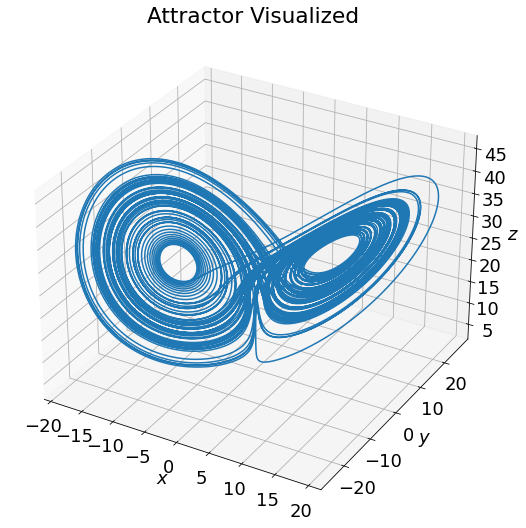

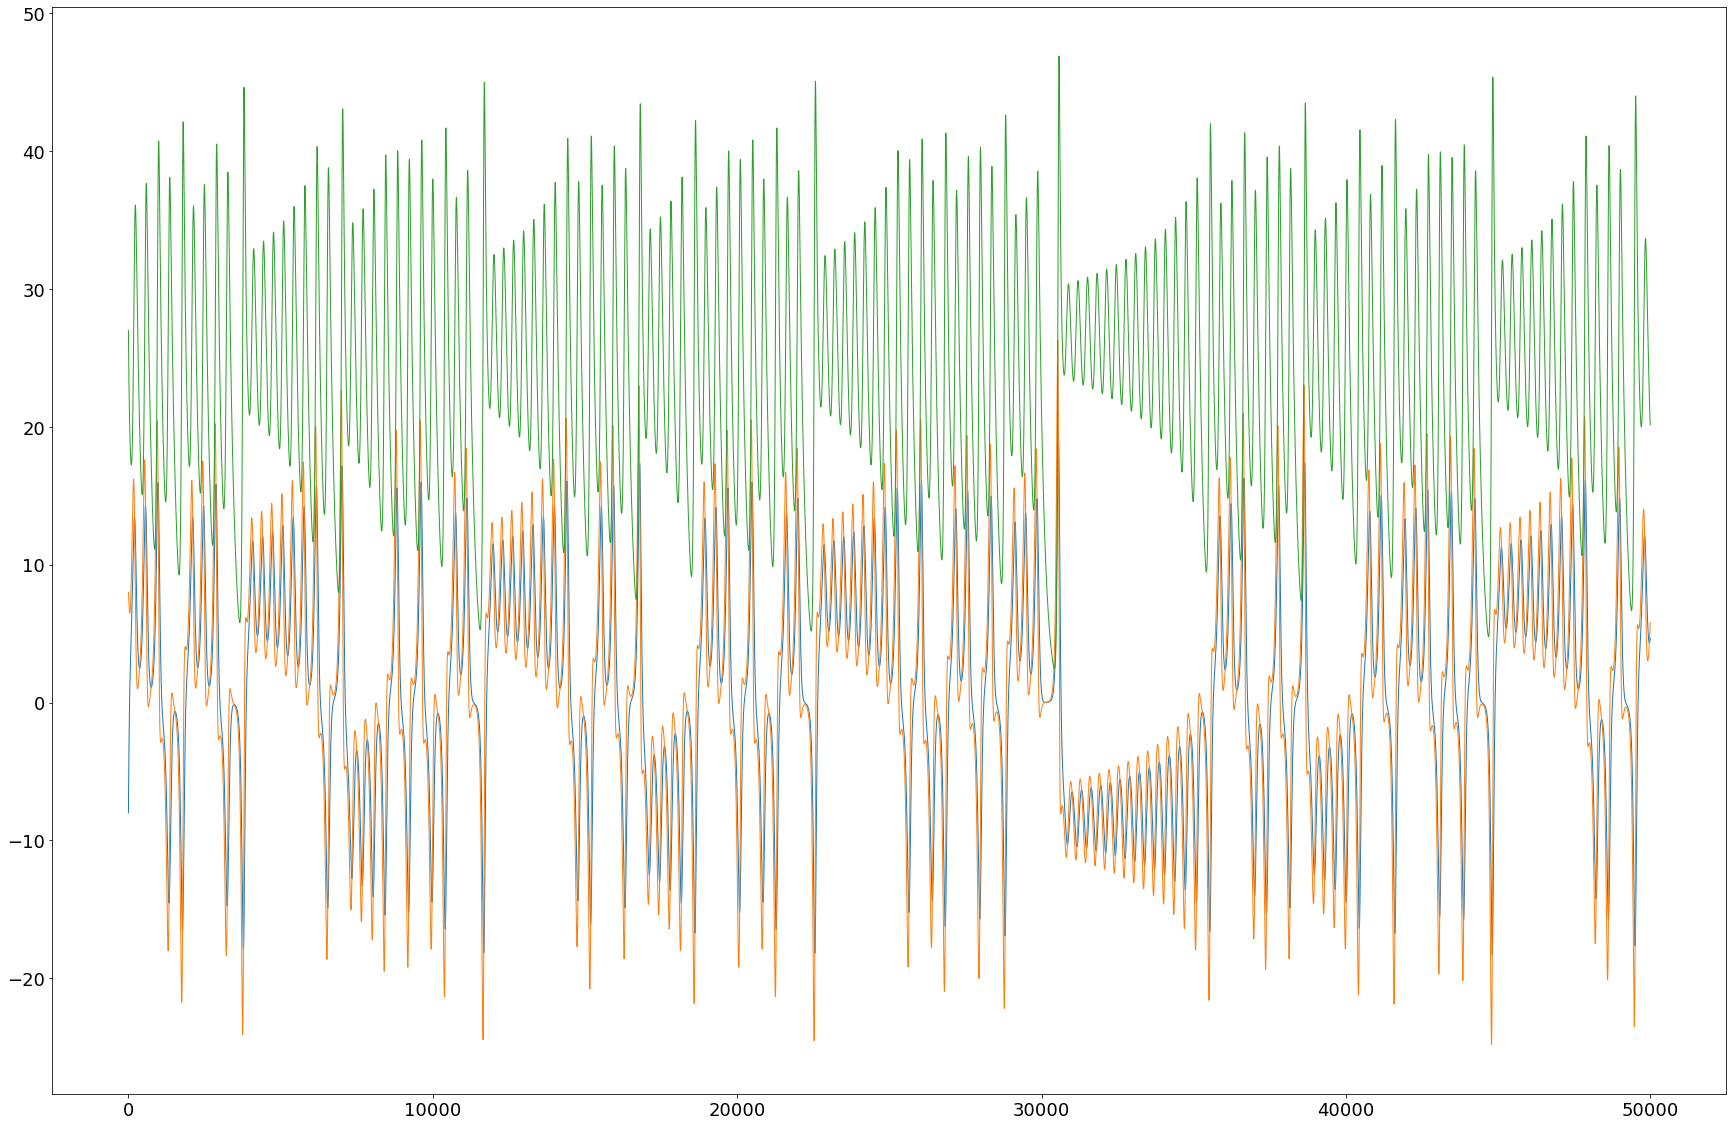

In [39]:
attractor = BobTheLorenzBuilder(10, 28, 2.66667, -8, 8, 27, 0.002)
attractor.MakeAttractor()
xt = attractor.MakeTensor()
attractor.VisualizeIt()

In [40]:
print(f"Shape of tensor: {xt.shape}")
print(f"Tensor dtype: {xt.dtype}")
print(f"Tensor location: {xt.device}")

Shape of tensor: torch.Size([50000, 3])
Tensor dtype: torch.float64
Tensor location: cpu
